---

This Colab was initially developed by [Jonathan Spencer](https://jspencer12.github.io) for the F2020 offering of _Safety-Critical Robotic Systems_.

---

### ECE 539/COS 512, Fall 2021
# Code Demo 4 - Inverse Reinforcement Learning

Inverse reinforcement learning (IRL) is a powerful tool in learning from demonstrations because it allows us to not only predict what humans might do, but reason about why they are doing them.

Stuart Russell has often been quoted saying that if a robot watches him demonstrate drinking coffee, he wants the robot to make him a cup of coffee, not to drink it for him. That nuance is the key, powerful difference between IRL and imitation learning. By inferring the human's reward, the robot can do much more than simply mimic them. The robot can help the human better than the human can help themself.

Here we'll be implementing the [Max Entropy IRL method](https://www.aaai.org/Papers/AAAI/2008/AAAI08-227.pdf), which serves as the basis for most modern IRL approaches.

This lab is organized as follows:
- [Gridworld](https://colab.research.google.com/drive/167QAMLf0wypZnRg9xkcf5iSvsx6Ty5fz?authuser=1#scrollTo=w60ICvpHcY4x&line=9&uniqifier=1) - We define the environment we're working in; most importantly, the transition probability matrix $P(s'|s,a)$
- [Feature Mapping and Reward Functions](https://colab.research.google.com/drive/167QAMLf0wypZnRg9xkcf5iSvsx6Ty5fz?authuser=1#scrollTo=0YaVeEWf7llV) - We discuss why we use feature maps and define a set of features for this problem.
- [Value Iteration](https://colab.research.google.com/drive/167QAMLf0wypZnRg9xkcf5iSvsx6Ty5fz?authuser=1#scrollTo=FwZIcQg-KQC3) - We implement the value iteration algorithm for finding the optimal policy/value given a reward.
- [Expert and Reward](https://colab.research.google.com/drive/167QAMLf0wypZnRg9xkcf5iSvsx6Ty5fz?authuser=1#scrollTo=j-FRlwovRO2C&line=1&uniqifier=1) - We define a set of reward parameters to generate "synthetic" expert demonstrations, or allow the user to write out their own demonstrations.
- [State Visitation Frequency](https://colab.research.google.com/drive/167QAMLf0wypZnRg9xkcf5iSvsx6Ty5fz?authuser=1#scrollTo=gteR1g4nJ5N4&line=13&uniqifier=1) - We solve for the time-average distribution of visited states given a specified policy
- [Max Entropy IRL](https://colab.research.google.com/drive/167QAMLf0wypZnRg9xkcf5iSvsx6Ty5fz?authuser=1#scrollTo=q8RyoltrmPCj&line=3&uniqifier=1) - We piece all those blocks together to solve the IRL problem

### Gridworld

The environment we'll use is a "gridworld." Think of our gridworld environment as a golf course. We have a goal, some nice grass, some tall grass, some sand, and some water. The action space is to move Up, Down, Left, Right, Stay, or End. We can also add in some randomness and say, for example, that if you choose to move in a particular direction, the "wind" might cause you to move +-90 degrees of your intended direction with some probability p. (i.e. if you choose to move Left, you'll either move Up or Down with probability p/2 in either direction)

Below I've made a function that generates a gridworld, where the goal is outlined in black. It's a pretty long chunk of code that you can mostly ignore unless you want to implement something similar yourself. (Probably should have made it as a proper class definition... ¯\\\_(ツ)_/¯)

The most salient feature of defining the gridworld is defining the 3D transition probability matrix `Psasp[s,a,s']`$=P(s'|s,a)$. We'll use this matrix in performing value iteration and in solving for the state visitation frequency. We keep it in matrix form for fast, vectorized computation, but as the state dimension increases, this becomes untenable, and you have to go back to defining the dynamics and doing interpolation as we did in the last lab.

You can play with the side length, random_seed, and class frequency parameters, but the ones I've set correspond to the "expert" reward parameters I define later, so probably leave them as is for now.

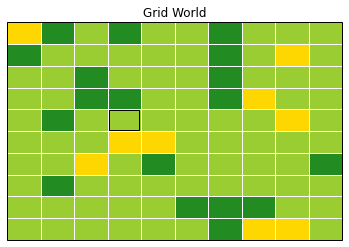

In [ ]:
import numpy as np
import scipy.special
import types
import time
import matplotlib.pyplot as plt
from matplotlib import patches,cm

#@markdown Function for building a 2D gridworld with a 1D index for vectorized function evaluation. Double click to reveal.
def build_gridworld(sidelens,class_freq=[1,1,1,1],random_seed=None,
                    state_classes = None, goal_inds = [],noise=0,
                    terminal_goal=False):
  '''Build a discrete gridworld environment.

    Movements are: [up,right,down,left,stay,end game]
    If noise is enabled, uopn choosing action a, you may be bumped +-90 deg of
    intended direction.
    Grid cells can be one of many classes (i.e. grass, long grass, sand, water)
    which are either assigned randomly using class_freq or specified explicitly
    using state_classes. The state classes are used for plotting and as features
    for the reward.

    The cells are stacked into a 1D array, which we use for indexing throughout
    We also build the transition probability matrix Psasp[s,a,s'] = P(s'|s,a)
    using the afforementioned movement/noise model.
    
    The "end game" action in every cell points to a terminal state hidden from
    the map at index gw.terminal_state that receives zero reward indefinitely

    input:
      sidelens      - tuple of rows and columns (i.e. [10,10])
      class_freq    - list of scalars, number is relative frequency of that class
      random_seed   - int or None for generating random state_classes
    (optional)
      state_classes - list of one-hot arrays specifying class of every state
      goal_inds     - list specifying index of goal(s) (purely cosmetic, outlines with box)
      noise         - float [0,1] probability of being diverted +- 90 deg of intended direction
      terminal_goal - bool (False) weather goal location should be an absorbing terminal state
          If True, this also eliminates "end" and "stay" actions.

    returns gridworld object with the following attributes:
      
      state_arr     - master list of coords. State indices refer to this list  (i.e. [(0,0), (0,1),...])
      Psasp         - matrix (S,A,S) transition prob. Psasp[s,a,s']=P(s'|s,a)
      terminal_state - int  absorbing terminal state index 
      state_classes - matrix (S,C) matrix of one-hot class identifiers
      valid_actions - matrix (S,A) binary matrix indicating whether action is valid
      S_dim         - int  State space dimension
      R_dim         - int  Row dimension
      C_dim         - int  Column dimension
      A_dim         - int  Action space dimension

      plot_grid     - func (colors,labels,title), plots arbitrary colors/labels on grid
      plot_gridworld - func (), plots this gridworld with color labels for classes
      plot_policy_value - func (pi,V,title) plots a value function with dominant action overlayed
      plot_trajs    - func (trajs,color) plots trajs as sequence of lines
      dist2sand     - array (S) - manhattan distance to sand-class states
    '''
  gw = types.SimpleNamespace()         # Somewhere to store gridworld
  gw.R_dim = sidelens[0]
  gw.C_dim = sidelens[1]
  gw.state_arr = np.stack([mat.flatten() for mat in np.meshgrid(np.arange(gw.R_dim),np.arange(gw.C_dim))],axis=1)
  gw.state_arr = np.vstack([gw.state_arr,[-1,-1]]) #Absorbing terminal cell
  gw.terminal_state = len(gw.state_arr)-1
  coord_dict = {tuple(coord):ind for ind,coord in enumerate(gw.state_arr)}

  gw.S_dim = len(gw.state_arr)
  gw.S_plot = len(gw.state_arr)-1 #Don't include absorbing state in plotting
  action_strs = ['up','right','down','left','stay','end']
  actions = [0,1,2,3,4,5]
  if terminal_goal:
    action_strs = action_strs[:4]
    actions = actions[:4]
  gw.A_dim = len(actions)
  gw.goal_inds = goal_inds

  # Generate state properties randomly
  np.random.seed(random_seed)
  if state_classes is None:
    gw.class_fracs = scipy.special.softmax(class_freq) #make sum to one
    gw.state_classes = np.random.multinomial(1,gw.class_fracs,size=gw.S_dim)
  else:
    gw.state_classes = state_classes
    gw.class_fracs = np.mean(state_classes,axis=0)
  #Assign colors to the classes
  gw.class_colors = ['yellowgreen','forestgreen','gold','skyblue'][:len(gw.class_fracs)]
  np.random.seed(None) #reset random seed

  #Terminal states
  terminal_states = [gw.terminal_state]
  if terminal_goal:
    terminal_states.extend(gw.goal_inds)

  ######################################
  ######### Generate transition probability matrix 
  gw.Psasp = np.zeros((gw.S_dim,gw.A_dim,gw.S_dim))
  valid_action_list = [[] for i in range(gw.S_dim)]
  gw.valid_actions = np.ones((gw.S_dim,gw.A_dim))
  action_deltas = np.array([[-1,0],[0,1],[1,0],[0,-1],[0,0]])
  action_deltas_L = np.array([[0,-1],[-1,0],[0,1],[1,0],[0,0]])
  action_deltas_R = np.array([[0,1],[1,0],[0,-1],[-1,0],[0,0]])
  for s in range(gw.S_dim):
    if s in terminal_states:   #If terminal, all actions send us to absorbing state
      gw.valid_actions[s,:] = 1
      valid_action_list[s] = actions
      gw.Psasp[s,:,gw.terminal_state] = 1
      continue
      
    # Resulting coordinates from taking action as well as noise
    sp_coords = gw.state_arr[s] + action_deltas[:gw.A_dim]
    sp_L_coords = gw.state_arr[s] + action_deltas_L[:gw.A_dim]
    sp_R_coords = gw.state_arr[s] + action_deltas_R[:gw.A_dim]
    # Verify whether actions (and noise) stay within grid
    valid_action_list[s] = [a for a,sp in enumerate(sp_coords) if tuple(sp) in coord_dict]
    gw.valid_actions[s,:len(sp_coords)] = [(tuple(sp) in coord_dict) for sp in sp_coords]
    valid_L = [a for a,sp in enumerate(sp_L_coords) if tuple(sp) in coord_dict]
    valid_R = [a for a,sp in enumerate(sp_R_coords) if tuple(sp) in coord_dict]
    # Populate transition probabilities
    for a in valid_action_list[s]:
      # Potential places noise could carry you
      noise_dests = [coord for LR,coord in enumerate([sp_L_coords[a],sp_R_coords[a]]) if a in [valid_L,valid_R][LR]]
      # Put all probability support on main action if no noise dests
      gw.Psasp[s,a,coord_dict[tuple(sp_coords[a])]] += 1-noise*(len(noise_dests)>0)
      # Spread remaining support evenly among all noise dests
      for coord in noise_dests:
        gw.Psasp[s,a,coord_dict[tuple(coord)]] += noise/len(noise_dests)
    #If we choose "end" option, go directly to terminal state
    if not terminal_goal:
      gw.Psasp[s,5,gw.terminal_state] = 1

  ### Verify that gw.Psasp is valid

  ############################
  ### Generic plotter, useful for visualing gridworld or value func
  def plot_grid(colors=None,labels=None,title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.patch.set_facecolor([1,1,1])     #Background color
    if colors is None:
      if labels is not None:
        colors = cm.Wistia((labels-min(labels[:gw.S_plot]))
                          /(max(labels[:gw.S_plot])-min(labels[:gw.S_plot]+1e-12)))
      else:
        return #If no args then do nothing
    for s in range(gw.S_plot):
      x = gw.state_arr[s,1]*1.0/gw.C_dim
      y = (gw.R_dim-1-gw.state_arr[s,0])*1.0/gw.R_dim
      #Add the patch
      ax.add_patch(patches.Rectangle((x,y),1.0/gw.C_dim,1.0/gw.R_dim,fill=True,
                                     fc=colors[s],ec=[1,1,1]))
      #Maybe add some text
      if labels is not None:
        format_str = '{}' if type(labels[s]) in [str,int,np.int32,np.int64] else '{:.2f}'
        ax.text(x+0.5/gw.C_dim, y+0.5/gw.R_dim, format_str.format(labels[s]),
                horizontalalignment='center',verticalalignment='center',
                fontsize=10,color='black')
        
      #Outline goal cell
      if s in gw.goal_inds:
        ax.add_patch(patches.Rectangle((x+.05/gw.C_dim,y+.05/gw.R_dim),
                           0.9/gw.C_dim,0.9/gw.R_dim,fill=False))
    #Add outline
    ax.add_patch(patches.Rectangle((0,0),1,1,fill=False,clip_on=False))
    if title is not None:
      plt.title(title)
    ax.set_axis_off()
  gw.plot_grid = plot_grid
  
  ## Build specific plotter for gridworld
  gw.colorvec = [np.select(gw.state_classes[i].astype(bool),gw.class_colors).item() for i in range(gw.S_dim)]
  gw.plot_gridworld = lambda : plot_grid(gw.colorvec,title='Grid World')

  ## Specific plotter for plotting value function and policy together
  def plot_policy_value(pi,V,title):
    arrows = [r'$\uparrow$',r'$\rightarrow$',r'$\downarrow$',r'$\leftarrow$','x','end'] 
    labels = ['{:.2f}\n{}'.format(V[n],arrows[np.argmax(pi[n,:])]) for n in range(gw.S_dim)]
    colors = cm.Wistia((V-min(V[:gw.S_plot]))/(max(V[:gw.S_plot])-min(V[:gw.S_plot])+1e-12))
    gw.plot_grid(colors,labels,title)
  gw.plot_policy_value = plot_policy_value

  ## Plots trajectories
  def plot_trajs(trajs,color='blue'):
    for traj in trajs:
      traj = [s for s in traj if s!=gw.terminal_state] #remove terminal state
      x_traj = (0.5+gw.state_arr[traj][:,1])/gw.C_dim
      y_traj = (gw.R_dim-0.5-gw.state_arr[traj][:,0])/gw.R_dim
      offset = np.random.randn(2)/500
      plt.plot(x_traj+offset[0],y_traj+offset[1],linewidth=1.5,color=color)
  gw.plot_trajs = plot_trajs

  ##############################
  # Function for computing distance to set of states for building features
  def compute_dist2states(targ_states):
    """
    Computes the distance to the closest state in targ_states from every cell
    using Bellman-Ford: dist(v,dest) = min_u(dist(u,v)+dist(u,dest)) \forall v
    
    in:  targ_states - list of state inds or 1D binary vector of len S_dim
    out: dist - 1D vector of manhattan distances
    """
    max_dist = gw.R_dim*gw.C_dim
    if type(targ_states) is list:
        targ_states = np.array([1 if i in targ_states else 0 for i in range(gw.S_dim)])
    dist = (np.ones(gw.S_dim)-targ_states)*max_dist

    converged = False
    while not converged: #Bellman-Ford: iterate V-1 times, or until no values change:
      converged = True
      for s in range(gw.S_plot):
        for a in valid_action_list[s]:
          if a < len(action_deltas): #this excludes the "terminate" action, which is fine for calculating distances
            neighbor = coord_dict[tuple(gw.state_arr[s] + action_deltas[a])]
            if dist[neighbor]+1 < dist[s]:
              converged = False
              dist[s] = dist[neighbor]+1
    return dist
  gw.dist2sand = compute_dist2states(gw.state_classes[:,2])
  #gw.dist2water = compute_dist2states(gw.state_properties[:,3])

  return gw

# Let's build one and plot it!
gw = build_gridworld([10,10],[3,2,1],random_seed=8,noise=.1,goal_inds=[34])
gw.plot_gridworld()

### Feature mapping and Reward functions

Since our gridworld has a discrete number of states, we could just define the reward function as an $|S|$ dimensional vector $\theta$, with one number for each state. Let $e_i$ be the $i$-th elementary vector (zeros with a 1 at i).

$r_\theta(s) = \theta^T e_s = \theta[s]$

This is both not scalable and uninformative. All we have done is to memorize for each particular state index what the reward value was, but in terms of generalizing to new environments we have learned nothing. This is where the idea of a feature map becomes useful. If we have a feature map that maps from state space to an $F$-dimensional real valued feature space $f:S\rightarrow \mathbb{R}^F$, then we can learn the reward as a function of features, which we can generalize across different state spaces.

$r_\theta(s) = \theta^T f(s)$

For simplicity of visualization, we consider reward as a function of state only, but we can easily have $f:S\times A\rightarrow \mathbb{R}^F$, and we consider the simple case of linear reward $r$, but $r_\theta$ can be a neural network or other differentiable functions.

In most of the code when we use reward and feature mapping, we us it in vector/matrix form rather than function form, so `F_mat` is a $(|S| \times F)$, `theta` is an $F$-dimensional vector, and `reward` is an $|S|$-dimensional vector with `reward = F_mat^T theta`.

Below we define and visualize some basic features in this environment.

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

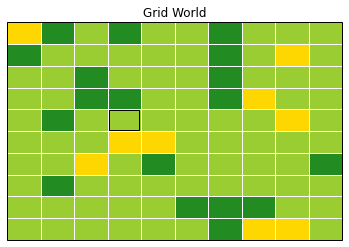

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

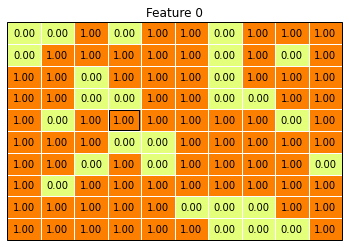

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

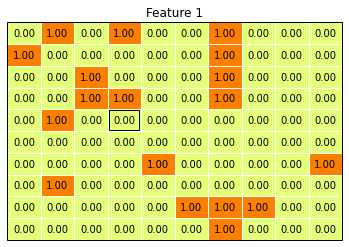

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

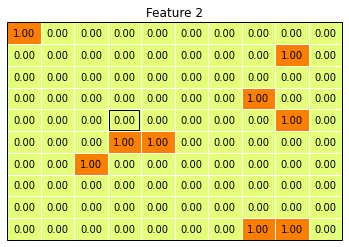

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

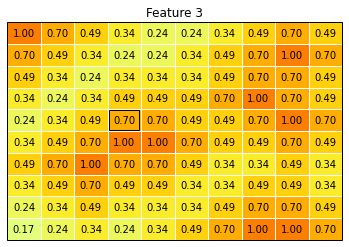

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

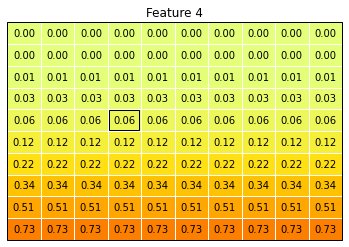

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

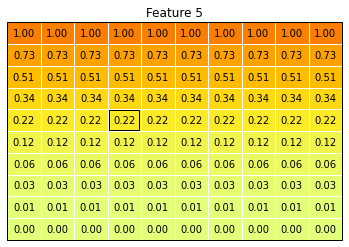

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

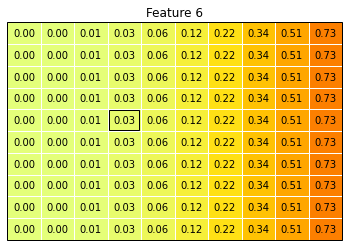

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

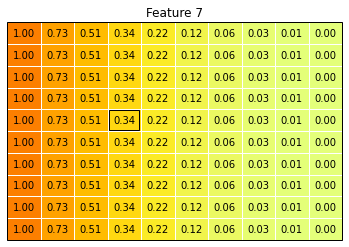

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

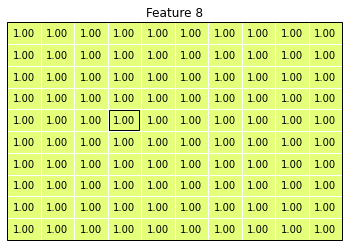

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
# Since we have a discrete state space, we can just write feature mapping as a
# matrix rather than a function

F_mat = np.hstack([gw.state_classes,                              # One-hot indicator of state class
                   np.power(.7,gw.dist2sand)[:,np.newaxis],       # Exponentially decaying distance to 'sand' features
                   (gw.state_arr[:,0]/gw.C_dim)[:,np.newaxis]**3,    # Distance to left side
                   (1-gw.state_arr[:,0]/gw.C_dim)[:,np.newaxis]**3,  # Distance to right side
                   (gw.state_arr[:,1]/gw.R_dim)[:,np.newaxis]**3,    # Distance from top
                   (1-gw.state_arr[:,1]/gw.R_dim)[:,np.newaxis]**3,  # Distance from bottom
                   np.ones((gw.S_dim,1))])                             # Bias term
F_mat[gw.terminal_state,:] = 0    #Terminal state is feature-less
F_dim = F_mat.shape[1]

grid = widgets.Grid(1,2)
with grid.output_to(0,0):
  gw.plot_gridworld()
with grid.output_to(0,1):
  tb = widgets.TabBar([f_ind for f_ind in range(F_dim)])
  for f_ind in range(F_dim):
    with tb.output_to(f_ind):
      gw.plot_grid(labels=F_mat[:,f_ind],title=f'Feature {f_ind}')
      plt.show()


### Value Iteration

A key ingredient in IRL is the forward solution: given a reward function $r(s,a)$, what is the corresponding optimal policy $\pi^*(a|s)$. This is exactly the RL problem, and it is the reason why IRL is often computationally heavy. We must solve the RL problem at every iteration. Luckily, in discrete space, rather than solving for $\pi^*$ using RL, we can find it using value iteration.

Value Iteration is simple. We begin by writing out the definitions of the optimal $Q$ and value functions.

$Q^*(s,a) = r(s,a) + \gamma E_{s'\sim P(s'|s,a)}[V^*(s')]$

$V^*(s) = \max_{a'} Q^*(s,a')$

These definitions are also fixed point solutions. We can initialize $V$ arbitrarily and alternate between calculating $Q$ and $V$ for every state. This process is guaranteed to converge since the argmax acts as a contraction. Once we have converged to a fixed point solution, we know we have the optimal solution since it satisfies the definition.

Below, I've written a function for value iteration which takes as an input a vector with the reward for every state and dynamics matrix `Psasp` and returns the optimal policy and value function. Try coding this part yourself and see if you can produce the same output



In [ ]:
#########################
#### Coding exercise ####
#########################
#
# Implement a function to solve value iteration as defined above using the
# specified in the function description

def value_iteration(reward,Psasp,valid_actions,discount=0.8,max_iter=50,**kwargs):
  """
  Performs fixed point Bellman updates to find optimal value and policy

  inputs:
    reward         vector (S) - reward of each state
    Psasp          matrix (SxAxS) - P[s,a,s'] is probability of reaching s' 
                      when starting at state s and taking action a
    valid_actions  matrix (SxA) - binary indication of whether action a is valid
                      from state s at index [s,a]
    discount       float - reward discount factor
    max_iter       int - max number of VI iterations to perfom
  outputs:
    pi_mat         matrix (SxA) - pi_mat[s,a] is the probability of the
                      optimal agent choosing action a while in state s for
                      the provided reward function and discount factor
    V              vector (S) - the optimal value function
  """
  S_dim,A_dim = Psasp.shape[0],Psasp.shape[1]

  ### Populate me! ###
  
  V = np.zeros(S_dim)
  pi_opt = np.zeros((S_dim,A_dim))
  return pi_opt, V

In [ ]:
#@markdown \*\*Hidden Demo Code\*\* (Double Click to Reveal, see prev cell for instructions)
def value_iteration(reward,Psasp,valid_actions,discount=.8,max_iter=50,
                    thresh=10**-2,soft=False,entropy_coef=.1,verbose_level=0):
  """
  Performs fixed point Bellman updates to find optimal value and policy

  Q*(s,a) = r(s,a) + discount*E_{s'~Psasp(s'|s,a)}[V*(s')]   
  V*(s) = max_{a'} (Q*(s,a'))
  pi*(a|s) = argmax_{a'} (Q*(s,a'))

  Solution is found by initializing V arbitarily, then iteratively calculating
  Q* and V* until convergence.
  
  Standard value iteration finds pi which solves the optimization
      pi*(a|s) = argmax_{pi} sum_t E_{s,a~pi}[discount^t*(reward(s_t,a_t)]
  However, if we augment the objective
      pi*(a|s) = argmax_{pi} sum_t E_{s,a~pi}[discount^t*(reward(s_t,a_t) 
                                              + alpha*H(pi(·|s_t))]
  where H is the entropy function, this leads to a slightly different set of
  updates known as the Soft Bellman updates (Thm 6.8, Ziebart Thesis), which
  is used in the original derivation of MaxEnt IRL. The only difference in the 
  Value Iteration is a switch from the hard 'max' to a soft approximation 
  'log sum exp', and the addition of the entropy coefficient alpha.
  V*(s) = alpha x log( sum_{a'} exp (1/alpha x Q*(s,a')) )
  pi*(a|s) = exp((Q*(s,a)-V*(s))/alpha) 
  
  The motivation for MaxEnt methods generally and the soft bellman updates
  specifically is to match provided statistics while staying as random as
  possible. It also has the bonus that it produces a soft policy in a
  principled way. For further explanation, refer to Ziebart's 2010 Thesis or
  "Reinforcement Learning with Deep Energy-Based Policies" Haarnoja '17.
  
  I have observed in practice that choosing alpha + discount > 1 causes it to
  misbehave.
  
  inputs:
    reward         vector (S) - reward of each state
    Psasp          matrix (SxAxS) - P[s,a,s'] is probability of reaching s' 
                      when starting at state s and taking action a
    valid_actions  matrix (SxA) - binary indication of whether action a is valid
                      from state s at index [s,a]
    discount       float - reward discount factor
    max_iter       int - max number of VI iterations to perfom
    soft           boolean - decides whether to do Soft or Hard value iter
    thresh         float - convergence threshold of value function
    entropy_coef   float - alpha in equation above
    verbose_level  int - >0 prints iteration info for debugging
  outputs:
    pi_mat         matrix (SxA) - pi_mat[s,a] is the probability of the
                      optimal agent choosing action a while in state s for
                      the provided reward function and discount factor
    V              vector (S) - the optimal value function
  """
  
  S,A = Psasp.shape[:2]
  alpha = 1.0*entropy_coef
  style = soft*'Soft'+(not soft)*'Hard'
  
  #reward = (reward-np.min(reward))/(np.max(reward)-np.min(reward)+1e-12)

  V = np.zeros(S)#*min(reward);
  last_V = np.zeros(S)
  n_VI = 0
  delta = thresh 

  # Main Value Iteration Loop
  #############################################
  while n_VI<max_iter and delta>=thresh:
    last_V[:] = V[:]
    Q = np.outer(reward,np.ones(A)) + discount*np.inner(Psasp,(V))
    if soft:
      #Ensure numerical stability and don't let this blow up
      #Q -= np.max(Q)
      #if np.max(np.abs(Q))/alpha >80:
      #  Q = Q*.8 
          
      V = alpha*np.log(np.sum(np.exp(1.0/alpha*Q)*valid_actions,axis=1))
      #if np.isinf(V).any():
      #  print(Q,np.sum(np.exp(1.0/alpha*Q)*valid_actions,axis=1),last_V)
    else:
      V = np.max(Q - (1-valid_actions)*10**15,axis=1)

    n_VI += 1
    delta = max(abs(V-last_V))
  ##############################################

  if verbose_level>0:
    print(f'{style} VI complete: delta={delta:.1e} after'\
          f' {n_VI}(max={max_iter}) iterations')

  pi_mat = np.zeros((S,A))
  if not soft:
    pi_opt = np.argmax(Q - (1-valid_actions)*10**15,axis=1)
    for s in range(S):
      pi_mat[s,pi_opt[s]] = 1
  else:
    pi_mat = np.exp(Q/alpha)*valid_actions/np.outer(np.exp(V/alpha),np.ones(A))
  
  return pi_mat, V

Below we test out the value iteration for a simple reward that is one at the goal, negative one next to the goal and zero elsewhere. Play with the convergence threshold and discount factor and notice how the output and number of VI iterations changes.

Some questions to ponder:
- Why is the value at the goal greater than one?
- We might expect the value in the states around the goal to be equal to the value at goal to be equal to the goal times the discount factor. Why is this not the case?
- Why does the discount factor influence the number of VI iterations?
- Directly to the left of the goal is a reward of -1, but the "optimal" policy cruises right through it. Why?

Several of those answers are linked to the fact that the optimal policy never chooses the "End Game" action, and just chooses the "Stay" action repeatedly. We can change this by forcing the game to end once the user picks the goal by adding the argument `terminal_goal=True` Notice how the value function changes when this is the case.
- Why is the value function different when the goal state is terminal?
- How do you anticipate the optimal value/policy would look if all the zero states were slightly negative (i.e. `-0.1*np.ones(gw.S_dim)`)? What about slightly positive?
- Try that out. Does it match your intuition?

Finally, set all the rewards = 1 and leave `terminal_goal=True`. Do the same for all the rewards = -1. Think about why. 
By making the goal state terminal, it directs the value function towards the goal even though the reward was identical. For the remainder of this code, we'll leave `terminal_goal=False` since we don't know a priori what is the goal state is, and by forcing a particular state to absorb, we're conveying additional information not captured in the feature function.

Hard VI complete: delta=5.6e-04 after 17(max=50) iterations


,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

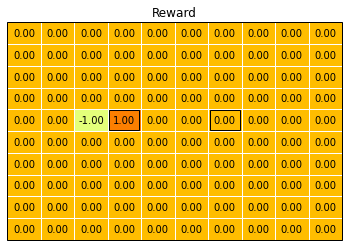

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

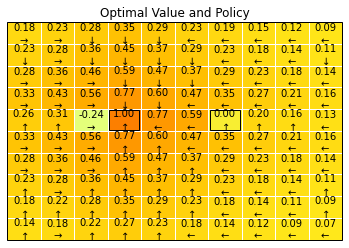

<IPython.core.display.Javascript object>

In [ ]:
#@title Testing Value Iteration {run: "auto"}
gw = build_gridworld([10,10],[3,2,1],random_seed=8,noise=.1,terminal_goal=True,goal_inds=[34,64])
thresh = 0.001    # VI convergence threshold
discount = 0.8 # @param {type:"slider", min:0, max:1,step:0.01}

# Simple reward for achieving goal (ignores classes of grass, sand, etc...)
reward = np.zeros(gw.S_dim)
reward[gw.goal_inds[0]] = 1
reward[gw.goal_inds[0]-10] = -1

# Perform value iteration for specified reward
pi_opt,V = value_iteration(reward,gw.Psasp,gw.valid_actions,thresh=thresh,
                           discount=discount,verbose_level=1)

# Plot things
grid = widgets.Grid(1,3)
with grid.output_to(0,1):
  gw.plot_grid(labels=reward,title='Reward')
with grid.output_to(0,2):
  gw.plot_policy_value(pi_opt,V,title='Optimal Value and Policy')

### Expert and Reward

Another key ingredient in IRL is the set of expert demonstrations $\mathcal{D}_E$, because that is our only window into the expert's true underlying reward $r_\theta$(s). How does the expert feel about tall grass? How does the expert feel about sand? (I don't like sand. It's coarse, and rough, and irritating. It gets everywhere.) The premise of IRL is that we only know these things inasmuch as the expert demonstrates them.

For validation purposes, it's helpful to choose a set of weights $\theta$, perform value iteration to find the optimal expert with respect to that reward, then generate some trajectories using that expert. Then once we perform IRL and recover $\hat{\theta}$, we can directly compare how close the recovered weights are to the true weights. For the sake of repeatability, I do this below, but you should totally define your own expert demonstration trajectories and see later on what is the reward function that we recover.

Although a trajectory is typically a sequence of states and actions $\tau = [(s_0,a_0),(s_1,a_1),...,(s_T,a_T)]$, we actually only care about the distribution of states. In generating our synthetic expert demonstrations, we include environmental noise, so if you've set the noise parameter above zero and want to be completely honest, you should flip a biased coin at every step to determine whether you've been affected by wind. ...or just set the gridworld noise parameter to zero.

Regardless of whether you give your own demonstrations or use the expert, pay attention to how the number of demonstrations affects the converged reward.



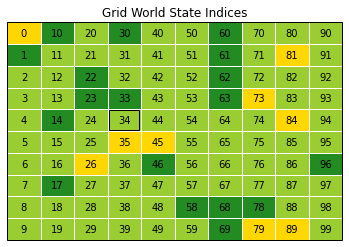

In [ ]:
# Plot gridworld with state indices for generating human trajectories
gw.plot_grid(colors=gw.colorvec,labels=np.arange(gw.S_dim),title='Grid World State Indices')

In [ ]:
############################
#### User Defined Demos ####
############################

# Define your own demos as a list of state sequences.
# Make all the trajectories fixed length, hanging out in the goal until the end
expert_demos = [[31,32,33,34,34,34,34,34,34],
                [45,56,55,54,44,34,34,34,34]]
# If you define your own demos, be sure to run this cell and not the next two cells

In [ ]:
# Construct expert reward function
#  long grass is -1, sand is -3, and distance weights are tuned specifically for 
#  goal @ state 34 (per 10x10 grid with random_seed=8)
theta_E = np.array([1.2,-.5,-2,0,-2,-.9,-2,-.4,-.7])
reward = np.dot(F_mat,theta_E)

Hard VI complete: delta=4.7e-05 after 22(max=100) iterations


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

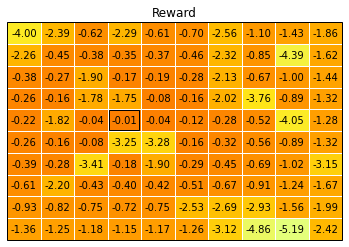

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

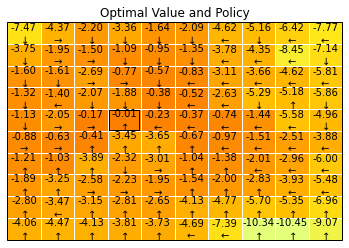

<IPython.core.display.Javascript object>

In [ ]:
#@markdown Boring code for generating expert trajectories given reward. Double click to reveal
def generate_expert_demos(num_demos,pi_expert,gw,max_len):
  """
  Generates a list of variable length expert demonstrations which only
  terminate when they reach states flagged in 'is_terminal'
  inputs:
      num_demos       int - number of demos to generate
      pi_expert       matrix (SxA) - expert policy function
      gw              gridworld object with:
        gw.Psasp      matrix (SxAxS) - P[s,a,s'] is probability of reaching
                          s' when starting at state s and taking action a
        gw.terminal_state   int - state index to end trajectories
        gw.S_dim      
      is_terminal     vector (S) - binary indicator if state is terminal
  outputs:
      expert_demos    list of lists (M) - each list is a sequence of state
                        indices of expert trajectory
  """
  expert_demos = []
  for m in range(num_demos):
    traj = [np.random.randint(gw.S_dim-1)]      #initial location is random (but not terminal)   
    while (len(traj)<max_len) and traj[-1]!=gw.terminal_state:
      s = traj[-1]
      a = np.argmax(pi_expert[s,:])
      sp = np.random.choice(np.arange(gw.S_dim),p=gw.Psasp[s,a,:])
      traj.append(sp)
    expert_demos.append(traj)
  return expert_demos



# Solve for pi_expert
gw = build_gridworld([10,10],[3,2,1],random_seed=8,noise=.1,terminal_goal=True,goal_inds=[34])
pi_expert,V_expert = value_iteration(reward,gw.Psasp,gw.valid_actions,thresh=.0001,
                              discount=.91,verbose_level=1,max_iter=100)

expert_demos = generate_expert_demos(50,pi_expert,gw,gw.R_dim*gw.C_dim)

# Plot things
grid = widgets.Grid(1,2)
with grid.output_to(0,0):
  gw.plot_grid(labels=reward,title='Reward')
with grid.output_to(0,1):
  gw.plot_policy_value(pi_expert,V_expert,title='Optimal Value and Policy')


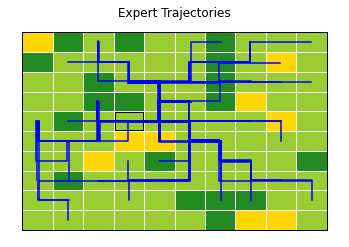

In [ ]:
# Visualize trajectories (whether synthetic or hand crafted)
gw.plot_grid(colors=gw.colorvec,title='Expert Trajectories')
gw.plot_trajs(expert_demos)

If you used the synthetic trajectories generated by my crudely tuned reward parameters, you may disagree with some of the demonstrations. Namely, you may notice the optimal policy has several cells with `x` in them, denoting the decision to stay, while you and I would have persevered on to find a way to the goal.

Can you explain what factors influcene the "optimal" policy to stop in each of those cells, even though the goal cell has the lowest value? (One answer is that our feature representation may simply not be expressive enough, but there are more answers)

### State Visitation Counts
The final building block we need to craft our IRL algorithm is calculating the state visitation frequency. That is, given a policy $\pi(a|s)$, what is the average distribution of states $d_\pi$ visited by that policy, where $d$ is an $|S|$ dimensional probability simplex, whose entry $s=p(s)$. This is given by the average over all timesteps of the distribution at that timestep.

$d_\pi = \sum_{t=1}^T d_\pi^t$

We calculate the distribution for a given timestep recursively by pushing through the policy and the dynamics

$d_\pi^t(s') = \sum_{s,a} d_\pi^{t-1}(s)\pi(a|s)P(s'|a,s) $


This is taking all possible combinations of $s$ and $a$ which arrive at $s'$, gathering their initial probability, then summing it up after weighing by the probability of choosing that action under $\pi$ and the probability of the environment bringing you there. Since we have $P$ in matrix form, we can do this computation rather quickly. The initial state distribution $d_\pi^0$ is the initial state distribution of the Markov Decision Process, and is usually specified as $\rho_0$, however we can often assume a uniform distribution of states.

Write a function to calculate the state visitation frequency, and check your answer against the demo code provided. Can you get yours to run faster than mine? :)

In [ ]:
#########################
#### Coding exercise ####
#########################
#
# Implement a function to calculate the state visitation frequency

def state_visitation_count(pi,Psasp,max_len,init_dist=None):
  '''
  Calculates avg state distribution given pi, P(s'|s,a)

  d_0 = MDP init distribution
  d_t(s') = \sum_{s,a parents of s'} d_{t-1}(s)\pi(a|s)P(s'|a,s) \forall s'
  d = 1/T \sum_t d_t

  input:
    pi      - matrix (SxA)  policy probabilities
    Psasp   - matrix (SxAxS)  MDP transition probabilities
    max_len - int  maximum trajectory length
  output:
    d_avg   - average state visitation for pi
  '''
  S = Psasp.shape[0]; A = Psasp.shape[1]
  d_init = 1.0/S*np.ones((S)) if init_dist is None else init_dist #assume uniform i
  
  #### Fill me in!
  return

In [ ]:
#@markdown \*\*Hidden Demo Code\*\* (Double Click to Reveal, see prev cell for instructions)
def state_visitation_count(pi,Psasp,max_len,init_dist=None):
  '''
  Calculates avg state distribution given pi, P(s'|s,a)

  d_0 = MDP init distribution
  d_t(s') = \sum_{s,a parents of s'} d_{t-1}(s)\pi(a|s)P(s'|a,s) \forall s'
  d = 1/T \sum_t d_t

  input:
    pi      - matrix (SxA)  policy probabilities
    Psasp   - matrix (SxAxS)  MDP transition probabilities
    max_len - int  maximum trajectory length
  output:
    d_avg   - average state visitation for pi
  '''

  S = Psasp.shape[0]; A = Psasp.shape[1]
  D = np.zeros((S,max_len))
  D[:,0] = 1.0/S*np.ones((S)) if init_dist is None else init_dist #assume uniform i
  for t in range(1,max_len):
    D[:,t] = np.sum(np.rollaxis(np.tile(np.outer(D[:,t-1],np.ones(A))*pi,[S,1,1]),0,3)
                    *Psasp,axis=(0,1))
  D_avg = np.sum(D,axis=1)
  return D_avg

In the following block, play with different values for `max_len`, the horizon $T$ over which we sum to find $d_\pi$, notice why it changes, and think about why that is. What should we set that value to when solving for the state visitation frequency?

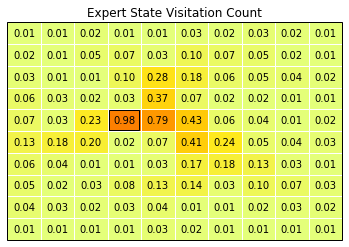

In [ ]:
#@title Testing the state visitation frequency code {run:"auto"}
max_len = 15 #@param {type:"slider", min:1, max:50,step:1}
SVF = state_visitation_count(pi_expert,gw.Psasp,max_len=max_len)
#SVF = SVF/np.sum(SVF[:-1])  #Exclude terminal in normalization
gw.plot_grid(labels=SVF,title='Expert State Visitation Count')

## Max Entropy IRL

The motivation behind max entropy IRL is that we wish to choose the policy which is as random as possible, while still matching the expected feature counts of the expert. We want to be as uncommitted/unbiased as possible to anything other than matching observed feature expectations.

For a given set of demonstrations $\mathcal{D}$, that optimization is:

$\max_\pi H(\pi) ~s.t. E_{s\sim\pi}[f(s)]=E_{s\sim\mathcal{D}}[f(s)]$

where $H(\pi)$ or $H(s\sim\pi)=-\sum_s p(s)\log(p(s))$.

If you go through the math (in the linear case), (see [“Maximum Entropy
IRL”, Ziebart ‘08](https://www.aaai.org/Papers/AAAI/2008/AAAI08-227.pdf)) this induces the following probability distribution over demonstrated trajectories/actions:

$p(s|\theta) = \frac{1}{Z}\exp(r_\theta(s))=\frac{\exp(r_\theta(s))}{\sum_{\tilde{s}\in S}\exp(r_\theta(\tilde{s}))}$

In the MaxEnt formulation, demonstrated trajectories are sampled from a distribution where high reward are exponentially more probable. The solution is to choose the parameters which maximize the likelihood (or log-likelihood $L_\theta(s)=\log p(s|\theta)$) under the set of observed expert states.

$\theta^* = \arg\max_\theta p(s|\theta) = \arg\max_\theta L_\theta$

In order to perform that minimization, we take gradient steps in $L$, which simplify to the following:

$\begin{align}\nabla_\theta L &= \sum_{s\sim\mathcal{D}} \nabla_\theta r_\theta(s) - E_{\tilde{s}\sim p(\tilde{s}|\theta)}[\nabla_\theta r_\theta(\tilde{s})] \\&= \sum_{s\sim\mathcal{D}} \nabla_\theta r_\theta(s) - \sum_{\tilde{s}\in S} p(\tilde{s}|\theta)\nabla_\theta r_\theta(\tilde{s})\end{align}$

At this point, if r is parameterized using a neural network, we backpropagate this difference through the network (using a few tricks to estimate the right term via [Wulfmeier, '15](https://arxiv.org/pdf/1507.04888.pdf)). In our case, however, this simplifies even further since we are using linear reward functions. Let $\mu_\pi=E_{s\sim\pi}[f(s)]$ be the vector of expected feature counts. The gradient simplifies further:

$\begin{align}\nabla_\theta L 
&= \sum_{s\sim\mathcal{D}} \nabla_\theta ~\theta^T f(s) - \sum_{\tilde{s}\in S} p(\tilde{s}|\theta)\nabla_\theta ~\theta^T f(\tilde{s}) \\
&= \sum_{s\sim\mathcal{D}} f(s) - \sum_{\tilde{s}\in S} p(\tilde{s}|\theta) f(\tilde{s}) \\
&= \mu_\mathcal{D} - \mu_{\pi_\theta}\end{align}$

With this fact, we can now write out the algorithm

**Max Ent IRL Alg** : (initialize $\theta_0$ arbitrarily, calculate expert feature expectation $\mu_\mathcal{D}$ from demos $\mathcal{D}$)
1. Use value iteration to find the optimal policy $\pi_{\theta_i}$ given reward $\pi_{\theta_i}$
2. Calculate the state visitation frequency $p(s|\theta_i)$ induced by following $\pi_{\theta_i}$.
3. Use $p(s|\theta_i)$ to calculate current feature expectation $\mu_{\pi_{\theta_i}}$
3. Compute gradient $\nabla_\theta L = \mu_\mathcal{D} - \mu_{\pi_{\theta_i}}$
4. Take a gradient step $\theta_{i+1} = \theta_i+\nabla_\theta L$ and iterate.

Below you'll find the implementation of Max Entropy IRL. If you'd like to implement it yourself, create a new codeblock here.

In [ ]:
def LinearMaxEntIRL(demos,gw,feature_map,learning_rate,discount_rate=0.9,
              entropy_coef=0.05,max_iter=50,SVF_max_len=15,conv_thresh=0.001,verbose_level=1):
              
  """
  inputs:
    demos              list (len M) - each item is an expert demo, represented
                         as a list, a sequence of states visited
    gw                 gridworld object with
     gw.Psasp          matrix (SxAxS) - P[s,a,s'] is probability of reaching
                         s' when starting at state s and taking action a
     gw.valid_actions  matrix (SxA) - matrix for proper normalization in
                         value iteration process
    feature_map        matrix (SxF) - matrix mapping states to features
    learning_rate      float - gradient step size for reward function
    discount_rate      float - future reward discount in value iteration
    entropy_coef       float - entropy coefficient for soft value iteration
                        (a value of zero performs hard VI)
    max_iter           int - max number of iters for IRL and VI
    SVF_max_len        int - max length in SVF calculation
    conv_thresh        float - convergence threshold for both IRL and VI
    verbose_level      int - =1 prints iteration counts, >1 prints nested 
                        iteration counts (for debugging) 
  outputs:
    reward_params      vector (F) - learned reward parameters
    pi_opt             matrix (SxA) - optimal policy w.r.t. learned reward
    V_opt              vector (S) - optimal value w.r.t. learned reward
    SVF                vector (S) - State visitation frequency under pi_opt
    SVF_expert         vector (S) - State visitation frequency from expert
  """
  
  S = gw.Psasp.shape[0]; A = gw.Psasp.shape[1]; F = feature_map.shape[1]
  
  theta = np.ones(F)/F  #initialize reward parameters (random takes longer to
                        #converge than zero or one)
  
  #Expert state visitation frequencies and feature expectations
  SVF_expert = np.zeros(S)
  for m in range(len(demos)):
    for t in range(len(demos[m])):
      s_mt = demos[m][t]
      SVF_expert[s_mt] += 1
  SVF_expert = SVF_expert/len(demos)
  f_ave_expert = np.dot(feature_map.T,SVF_expert)
  
  ## Main loop
  n_iter_IRL = 0; 
  pi_curr = np.ones((S,A));
  pi_last = np.ones((S,A));
  V_curr = np.zeros(S)
  V_last = np.zeros(S)
  delta_IRL = conv_thresh
  gradient = np.zeros(F)
  grad_last = np.zeros(F)
  start_time = time.time()
  deltas = []
  while n_iter_IRL<max_iter:# and delta_IRL>=conv_thresh:
    n_iter_IRL += 1
    pi_last[:] = pi_curr[:]
    V_last[:] = V_curr[:]

    #Find optimal policy
    theta = theta/np.linalg.norm(theta)
    reward = np.dot(feature_map,theta)
    pi_curr, V_curr = value_iteration(reward,gw.Psasp,gw.valid_actions,soft=True,
                                      discount=discount_rate,max_iter=max_iter,
                                      thresh=conv_thresh,entropy_coef=entropy_coef,
                                      verbose_level=verbose_level-2)

    # Solve state visitation frequency
    SVF = state_visitation_count(pi_curr,gw.Psasp,SVF_max_len)
    #SVF = SVF/np.sum(SVF[:-1])  #Exclude terminal in normalization

    # Feature expectation
    f_ave = np.inner(feature_map.T,SVF)
    
    # Gradient step
    gradient = f_ave_expert-f_ave
    theta += learning_rate*gradient

    # Check convergence
    #delta_IRL = np.max(np.abs(pi_curr-pi_last))
    delta_IRL = np.max(np.abs(V_curr-V_last))
    deltas.append(delta_IRL)

    if verbose_level>1:
      #print(theta)
      print('IRL iter {}, delta = {:.1e}'.format(n_iter_IRL,delta_IRL))
    elif verbose_level==1:
      print('\rIRL iter {} of {}'.format(n_iter_IRL,max_iter),end='')

  if verbose_level>0:
    print('\rIRL complete: delta={:.1e} after {}(max={}) iterations, {:.1f} seconds'
            .format(delta_IRL,n_iter_IRL,max_iter,time.time()-start_time))
  
  if verbose_level>0:
    plt.semilogy(deltas,label='pi convergence')
    plt.legend()
    plt.xlabel('Iteration number')
    plt.title('Max difference between successive policies')
  return theta, pi_last, V_curr, SVF, SVF_expert


Let's play with some parameters! Max Entropy IRL has a *lot* of them.
- What is the fewest number of synthetic demonstrations that faithfully reproduces the reward?
- How does the discount rate affect the solution? What about adding environmental noise?
- What level of convergence threshold produces acceptable results?
- How much does the learning rate matter?
- Depending on the settings, there may be several cells where the agent chooses the "end" action. What accounts for their lack of will to continue? (Part of the answer is based on numerical stability in the $\log \sum \exp$ operation. How might you address this?)

IRL complete: delta=2.2e+00 after 1000(max=1000) iterations, 12.1 seconds


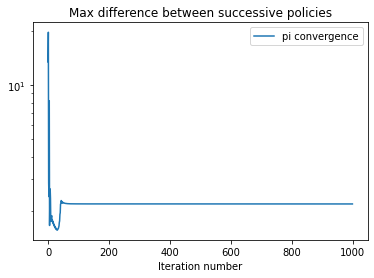

,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

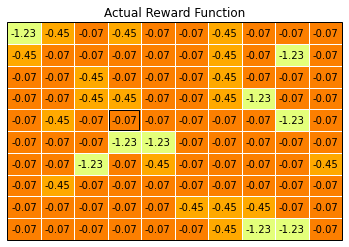

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

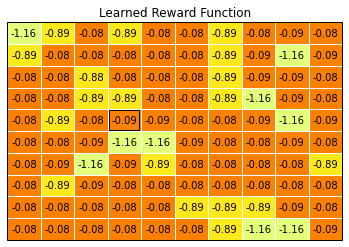

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

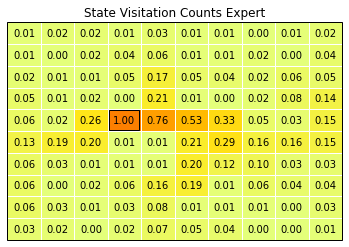

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

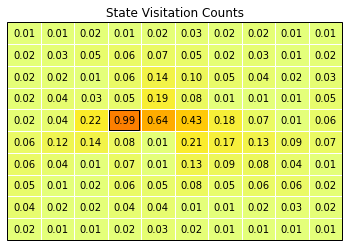

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

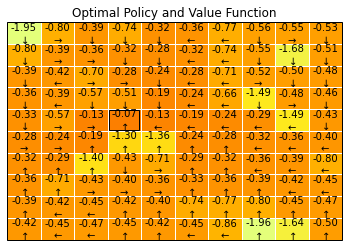

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

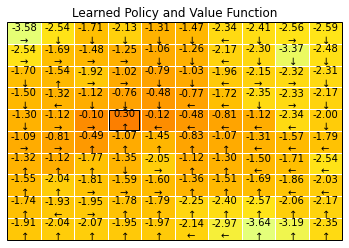

<IPython.core.display.Javascript object>

Feature Counts Expert:  [ 7.470  0.260  0.090  4.207  7.820]
Feature Counts Learner: [ 6.114  0.359  0.168  3.628  6.641]
Feature Weights Expert:  [ 0.269 -0.112 -0.896  0.000 -0.336]
Feature Weights Learner: [ 0.449 -0.357 -0.613 -0.025 -0.521]
Avg Traj Len - Expert: 8.82, Learner: 8.9


In [ ]:
### Params
env_noise = 0.01          # Probaility of being blown in a different direction from chosen
discount = 0.9            # 1/(1-discount) corresponds roughly to our max look-ahead time horizon
traj_maxlen = 30          # Maximum length of expert trajectories
N_demo = 100              # Number of expert demonstrations
max_IRL_iter = 1000       # Number of IRL iterations to perform
VI_entropy = 0.05          # Softness/randomness of pi_i in value iteration. Close to zero is normal value iteration, but is numerically unstable.
IRL_conv_thresh = 1e-3    # IRL/VI convergence threshold
IRL_learning_rate = .1     # weight to put on each IRL gradient step
feats = [0,1,2,3,8]

# Build a fresh gridworld
gw = build_gridworld([10,10],[3,2,1],random_seed=8,noise=env_noise,terminal_goal=True,goal_inds=[34])

# Redefine the features
F_mat = np.hstack([gw.state_classes,                              # One-hot indicator of state class
                   np.power(.7,gw.dist2sand)[:,np.newaxis],       # Exponentially decaying distance to 'sand' features
                   (gw.state_arr[:,0]/gw.C_dim)[:,np.newaxis]**3,    # Distance to left side
                   (1-gw.state_arr[:,0]/gw.C_dim)[:,np.newaxis]**3,  # Distance to right side
                   (gw.state_arr[:,1]/gw.R_dim)[:,np.newaxis]**3,    # Distance from top
                   (1-gw.state_arr[:,1]/gw.R_dim)[:,np.newaxis]**3,  # Distance from bottom
                   np.ones((gw.S_dim,1))])                             # Bias term
F_mat[gw.terminal_state,:] = 0    #Terminal state is feature-less
F_mat = F_mat[:,feats]

# Redefine the reward
theta_E = np.array([1.2,-.5,-4,0,-2,-.9,-2,-.4,-1.5])[feats]
theta_E = theta_E/np.linalg.norm(theta_E)
reward = np.dot(F_mat,theta_E)

# Solve for expert policy
pi_expert,V_expert = value_iteration(reward,gw.Psasp,gw.valid_actions,thresh=.0001,
                              discount=discount,verbose_level=0,max_iter=100)

# Generate some demonstrations
expert_demos = generate_expert_demos(N_demo,pi_expert,gw,max_len=traj_maxlen)

# Solve IRL!
theta_hat,pi_IRL,V_IRL,SVC_IRL,SVC_expert = LinearMaxEntIRL(expert_demos,gw,F_mat,learning_rate=IRL_learning_rate,
              discount_rate=discount,entropy_coef=VI_entropy,max_iter=max_IRL_iter,SVF_max_len=traj_maxlen,
              conv_thresh=IRL_conv_thresh,verbose_level=1)
grid = widgets.Grid(2,3)
with grid.output_to(0,0):
  gw.plot_grid(labels=reward,title='Actual Reward Function')
with grid.output_to(1,0):
  gw.plot_grid(labels=np.dot(F_mat,theta_hat),title='Learned Reward Function')
with grid.output_to(0,1):
  gw.plot_grid(labels=SVC_expert,title='State Visitation Counts Expert')
with grid.output_to(1,1):
  gw.plot_grid(labels=SVC_IRL,title='State Visitation Counts')
with grid.output_to(0,2):
  gw.plot_policy_value(pi_expert,V_expert,'Optimal Policy and Value Function')
with grid.output_to(1,2):
  gw.plot_policy_value(pi_IRL,V_IRL,'Learned Policy and Value Function')

with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print('Feature Counts Expert: ',np.dot(F_mat.T,SVC_expert))
  print('Feature Counts Learner:',np.dot(F_mat.T,SVC_IRL))
  print('Feature Weights Expert: ',theta_E)
  #print('Feature Weights Learner (reweighted):',theta_hat/theta_hat[0]*theta_E[0])
  print('Feature Weights Learner:',theta_hat)

# Generate some learner trajectories
learner_demos = generate_expert_demos(N_demo,pi_IRL,gw,max_len=traj_maxlen)
print('Avg Traj Len - Expert: {}, Learner: {}'.format(np.mean([len(x) for x in expert_demos]),
                                                      np.mean([len(x) for x in learner_demos])))

Well done! If you've followed along with the coding demos, you've now implemented Max Entropy Inverse Reinforcement Learning! And if you wrote out the demonstration trajectories yourself, then you've learned a generalizable reward function from demonstration alone.

If you're feeling ambitious try the following problem:

Let us assume we have two separate demonstration sets $\mathcal{D}_1$ and $\mathcal{D}_2$ of humans acting in multiple modes: i.e. walking towards top right corner vs walking towards bottom right corner. From these we can find reward functions describing each mode, $r_1$ and $r_2$. If we observe a partial trajectory, how might we decide which reward that agent is seeking? Is there a way we might determine whether the human is seeking neither of our specified rewards? Using the code we built for MaxEnt IRL, give this a try!

You can generate synthetic trajectories headed towards top right and bottom right using the following rewards:

```theta_E_TR = np.array([0,-1,-3,0,0,1,1,0,0])```

```theta_E_BR = np.array([0,-1,-3,0,1,0,1,0,0])```

Hope you find this exercise rewarding!